# Data preprocessing

## Compute the consumption by hour

In [42]:
import pandas as pd
from pathlib import Path
from pprint import pprint
from datetime import datetime, timedelta # to convert timestamp/ID to human readable format
from tqdm import tqdm

In [2]:
# load CSV files
raw_data = Path('rawdata')
tables = {}
for i, file in enumerate(raw_data.iterdir()):
    name = file.name.split('.')[0]
    tables[f"{name}"] = pd.read_csv(f"rawdata/{file.name}", header = None, names=('ID', name))

## Date transformation functions

In [4]:
def ticks_to_iso(ticks):
    """Convert .NET DateTime.Ticks to an ISO 8601 formatted string."""
    ticks_epoch = datetime(1, 1, 1)  # .NET starts from year 0001-01-01
    date_time = ticks_epoch + timedelta(microseconds=ticks / 10)  # Convert ticks to microseconds
    return date_time.isoformat()

def ticks_to_ymd(ticks):
    """Convert .NET DateTime.Ticks to an ISO 8601 formatted string."""
    ticks_epoch = datetime(1, 1, 1)  # .NET starts from year 0001-01-01
    date_time = ticks_epoch + timedelta(microseconds=ticks / 10)  # Convert ticks to microseconds
    return date_time.strftime("%Y-%m-%d")

# Adds date and ISO date to table in tables dictionary
def add_dates(table_name): 
    tables[table_name]["date"] = tables[table_name].ID.apply(ticks_to_ymd)
    tables[table_name]["iso_date"] = tables[table_name].ID.apply(ticks_to_iso)
   

In [83]:
# Join fuelDensity and fuelVolumeFlowRate
df_density = pd.read_csv("rawdata/fuelDensity.csv", header = None, names=('ID', 'fuelDensity'))
df_volFlow = pd.read_csv("rawdata/fuelVolumeFlowRate.csv", header = None, names=('ID', 'fuelVolumeFlowRate'))
df_fuel = df_density.merge(df_volFlow, on='ID')
# df_fuel = tables["fuelDensity"].merge(tables["fuelVolumeFlowRate"], on = "ID")

# 1) Add date, hour cloumns and fuelMassFlowRate
df_fuel["iso_date"] = df_fuel.ID.apply(ticks_to_iso)
df_fuel["dateHour"] = df_fuel.ID.apply(lambda x: ticks_to_iso(x)[:13])
df_fuel["fuelMassFlowRate"] = df_fuel.fuelDensity * df_fuel.fuelVolumeFlowRate

# 2) drop unecessary cols
df_fuel = df_fuel.drop('ID', axis=1)
df_fuel = df_fuel.drop(["fuelDensity","fuelVolumeFlowRate"], axis=1)

# TIMEDIFF

# 3) Change iso_date type to timestamp in order to compute time differences
df_fuel["iso_date"] = pd.to_datetime(df_fuel["iso_date"], format='ISO8601')

# 4) Drop lines where fuel flow is 0, IMPORTANT
#    time diffs must be calculated only for the engine runtime
#    or maybe I can skip that, at least I will have 0 consumption per hour in training dataset
df_fuel = df_fuel[df_fuel["fuelMassFlowRate"] != 0]

# 5) Add time diff
df_fuel["timeDiff"] = df_fuel.iso_date.diff()

# 6) Fill border line with 0 (only a small error)
df_fuel.timeDiff = df_fuel.timeDiff.fillna(pd.Timedelta(seconds=0))

# 7) Despite the efort to count make diffs only from runtime some non-sense timediffs occured.
#    Therefore I am going to filter them out. Sampling frequency was around 1.02 s
df_fuel = df_fuel[df_fuel["timeDiff"].dt.total_seconds() < 1.2]

# Compute fuel consumption for every interval
df_fuel["fuelMassConsumption"] = df_fuel.fuelMassFlowRate * df_fuel.timeDiff.dt.total_seconds()
df_fuel

,iso_date,dateHour,fuelMassFlowRate,timeDiff,fuelMassConsumption
4,2010-02-16 12:48:13.560688,2010-02-16T12,0.266306,0 days 00:00:00,0.000000
5,2010-02-16 12:48:14.582064,2010-02-16T12,0.261940,0 days 00:00:01.021376,0.267539
6,2010-02-16 12:48:15.603488,2010-02-16T12,0.265296,0 days 00:00:01.021424,0.270979
7,2010-02-16 12:48:16.626888,2010-02-16T12,0.263480,0 days 00:00:01.023400,0.269645
8,2010-02-16 12:48:17.649280,2010-02-16T12,0.262434,0 days 00:00:01.022392,0.268311
...,...,...,...,...,...
1627319,2010-04-12 22:25:12.142864,2010-04-12T22,0.189356,0 days 00:00:01.023416,0.193790
1627320,2010-04-12 22:25:13.164264,2010-04-12T22,0.190873,0 days 00:00:01.021400,0.194958
1627321,2010-04-12 22:25:14.186664,2010-04-12T22,0.197969,0 days 00:00:01.022400,0.202404
1627322,2010-04-12 22:25:15.208072,2010-04-12T22,0.208952,0 days 00:00:01.021408,0.213426


In [84]:
df_daily_consumption = df_fuel[["dateHour","fuelMassConsumption"]].groupby("dateHour").sum().apply(lambda x: x*0.001)


In [85]:
display(df_daily_consumption)
display(df_daily_consumption.info())
display(df_daily_consumption.describe())

,fuelMassConsumption
dateHour,
2010-02-16T12,0.309810
2010-02-16T13,1.672615
2010-02-16T14,1.663355
2010-02-16T15,0.329521
2010-02-17T06,0.520858
...,...
2010-04-12T18,1.772452
2010-04-12T19,1.901760
2010-04-12T20,0.596245


<class 'pandas.core.frame.DataFrame'>
Index: 682 entries, 2010-02-16T12 to 2010-04-12T22
Data columns (total 1 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   fuelMassConsumption  682 non-null    float64
dtypes: float64(1)
memory usage: 10.7+ KB


None

,fuelMassConsumption
count,682.000000
mean,1.330281
std,0.686605
min,0.003561
25%,0.675496
50%,1.486395
75%,2.013399
max,2.312076


In [13]:
df_fuel.describe()

,iso_date,fuelMassFlowRate,timeDiff,fuelMassConsumption
count,1626840,1.626840e+06,1626840,1.626840e+06
mean,2010-03-16 06:06:46.706343168,5.455613e-01,0 days 00:00:01.022207642,5.576771e-01
min,2010-02-16 12:48:13.560688,2.159260e-02,0 days 00:00:00,0.000000e+00
25%,2010-03-02 13:38:17.303463936,5.443790e-01,0 days 00:00:01.021376,5.564628e-01
50%,2010-03-15 21:02:59.776580096,5.801077e-01,0 days 00:00:01.022344,5.929853e-01
75%,2010-03-29 07:13:28.987108096,6.053773e-01,0 days 00:00:01.022432,6.188304e-01
max,2010-04-12 22:25:16.230472,8.806616e-01,0 days 00:00:01.056008,9.074478e-01
std,NaN,1.102407e-01,0 days 00:00:00.001420576,1.126915e-01


In [17]:
# df_daily_consumption.to_csv('daily_consumption.csv',header=True)

# Feature extraction

## Fuel Temperature
This property directly determines the fuel density.

In [23]:
def transform_feature(csvFile):
    feature_name = csvFile.split('/')[1].split('.')[0]
    df = pd.read_csv(csvFile, names=['iso_date', feature_name])
    df["date"] = df.iso_date.apply(ticks_to_ymd)
    df["iso_date"] = df.iso_date.apply(ticks_to_iso)
    df["dateHour"] = df.iso_date.apply(lambda x: x[:13])
    return df

In [8]:
def lost_hours(df_aggre, df_toMerge):
    n_0 = df_aggre.shape[0]
    n_1 = df_aggre.merge(df_toMerge, on='dateHour').shape[0]
    return abs(n_0 - n_1)

## GPS
To somehow to represent GPS information in numerical value, I will perform following transformation of signs:
(North ... +, South ... -, East ... -, West ... +)

In [6]:
def transform_gps(val):
    match val[-1]:
        case 'W':
            val = float(val[:-1])
        case 'E':
            val = float(val[:-1]) * (-1)
        case 'N':
            val = float(val[:-1])
        case 'S':
            val = float(val[:-1]) * (-1)
    return val

# Create dataset

In [5]:
def create_dataset(files):
        df = transform_feature(f"rawdata/{files}.csv")
        feature_name = files
        # transform GPS
        if feature_name in ("longitude", "latitude"):
            # transform to numeric
            df[feature_name] = df[feature_name].apply(transform_gps)
            # get extreme values
            df_min = df[['dateHour',feature_name]].groupby('dateHour').min()
            df_max = df[['dateHour',feature_name]].groupby('dateHour').max()
            # group exremes in df
            df_toMerge = df_max.merge(df_min, on='dateHour', suffixes=('_max','_min'))
            
        #all other features
        else:
            # calculate AVG value per hour
            df_toMerge = df[["dateHour",feature_name]].groupby("dateHour").mean()
        return df_toMerge

In [13]:
data = [
    'starboardRudder',
     'portPitch',
     'level2median',
     'latitude',
     'speedKnots',
     'longitudinalWaterSpeed',
     'trackDegreeTrue',
     'windSpeed',
     'trueHeading',
     'starboardPitch',
     'portRudder','processed_data/proto_dataset.csv',header=True
     'longitude',
     'level1median',
     'trackDegreeMagnetic',
     'inclinometer-raw',
     'windAngle',
     'speedKmh',
     'fuelTemp'
    ]

In [27]:
df_total = pd.read_csv('processed_data/daily_consumption.csv')
for file in tqdm(data):
    df_inter = create_dataset(file)
    df_total = df_total.merge(df_inter, on='dateHour')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 18/18 [03:38<00:00, 12.14s/it]


In [33]:
df_total.describe()
df_total.shape

(682, 22)

In [31]:
df_total.to_csv('processed_data/proto_dataset.csv',header=True)

## Division and scaling

In [76]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import ParameterGrid

### Spliting data

In [39]:
Xdata = df_total.drop(["fuelMassConsumption", "dateHour"], axis = 1)
ydata = df_total["fuelMassConsumption"]

rd_seed = 42


Xtrain, Xtest, ytrain, ytest = train_test_split(Xdata, ydata, test_size=0.3, random_state=rd_seed)
Xval, Xtest, yval, ytest = train_test_split(Xtest, ytest, test_size=0.5, random_state=rd_seed)
display(Xtrain.shape)
display(ytrain.shape)
display(Xval.shape)
display(yval.shape)
display(Xtest.shape)
display(ytest.shape)

(477, 20)

(477,)

(102, 20)

(102,)

(103, 20)

(103,)

### Scaling

In [40]:
scaler = StandardScaler()
Xtrain_scaled = scaler.fit_transform(Xtrain)
Xval_scaled = scaler.transform(Xval)

# Model selection

## Ridge regresion
Linear model is the simplest one, therefore it can be a good starting point. And slight regularisation should be also useful.

In [130]:
def train_ridge_alpha(begin, end, visual=True):
    alphas = np.linspace(begin, end, 50)
    RMSE = []
    r2 = []
    for alpha in alphas:
        clf_Ridge = Ridge(alpha = alpha)
        clf_Ridge.fit(Xtrain_scaled, ytrain)
        RMSE.append(root_mean_squared_error(yval, clf_Ridge.predict(Xval_scaled)))
        r2.append(r2_score(yval, clf_Ridge.predict(Xval_scaled)))
    if visual == True:        
        plt.plot(alphas, RMSE, '.')
        plt.show()
    return alphas, RMSE, r2

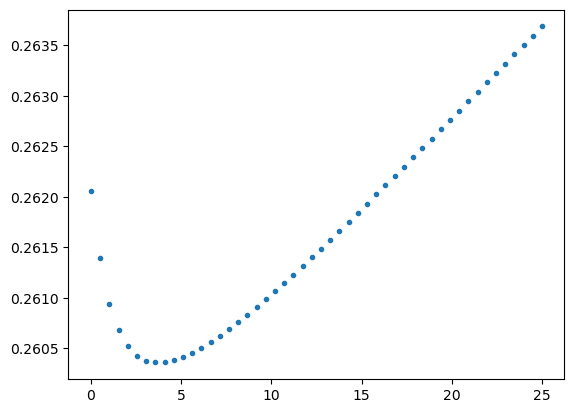

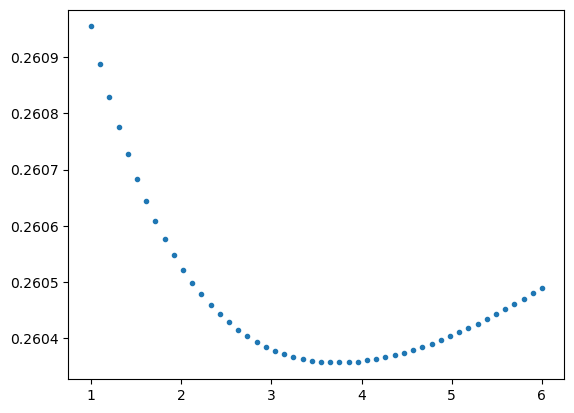

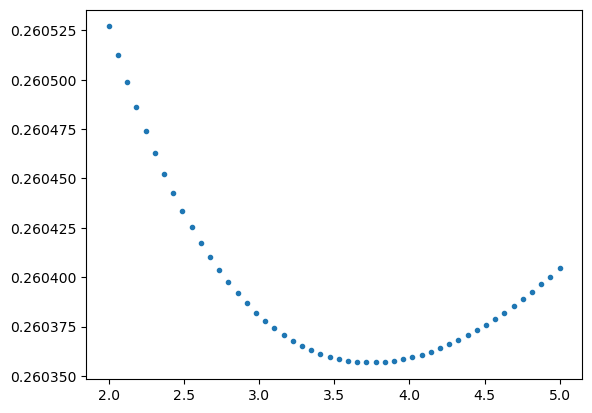

In [132]:
aplhas1, ridgeRMSE1, ridge_r2_01 = train_ridge_alpha(0,25)

alphas2, ridgeRMSE2, ridge_r2_02 = train_ridge_alpha(1,6)

alphas3, ridgeRMSE3, ridge_r2_03 = train_ridge_alpha(2,5)

In [133]:
print('Mean val consumption: ',yval.mean())
opt_alpha = np.argmin(ridgeRMSE3)
best_RMSE_ridge = np.min(ridgeRMSE3)
print('Best RMSE ridge:', best_RMSE_ridge)
best_R2_ridge = np.min(ridge_r2_03)
print('Best R2 SVM:', best_R2_ridge)
print(f'Best rel. RMSE {((best_RMSE_ridge/yval.mean())*0.01):.4f} %')

Mean val consumption:  1.305776401619324
Best RMSE ridge: 0.26035681841063574
Best R2 SVM: 0.8559114468876028
Best rel. RMSE 0.0020 %


## SVM
Now let's try SMV in order to introduce non-linearity.

In [86]:
from sklearn.svm import SVR

In [141]:
def train_SVR_C(begin, end, visual=True, zoom=1):
    Cs = [i/zoom for i in range(begin, end)]
    RMSE = []
    r2 = []
    for c in Cs:
        clf = SVR(kernel = 'rbf',C = c)
        clf.fit(Xtrain_scaled, ytrain)
        ypred = clf.predict(Xval_scaled)
        RMSE.append(root_mean_squared_error(yval, ypred))
        r2.append(r2_score(yval, ypred))
    if visual == True:        
        plt.plot(Cs, RMSE, '.')
        plt.show()
    return Cs, RMSE, r2

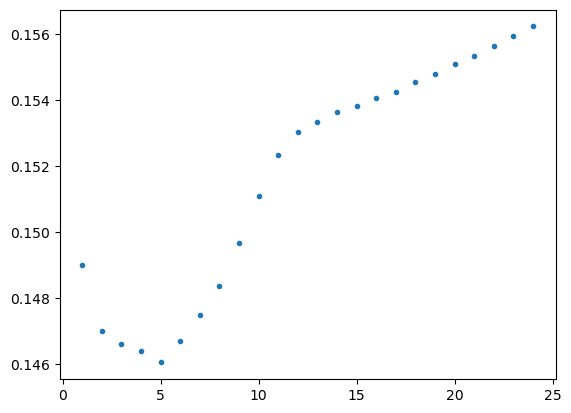

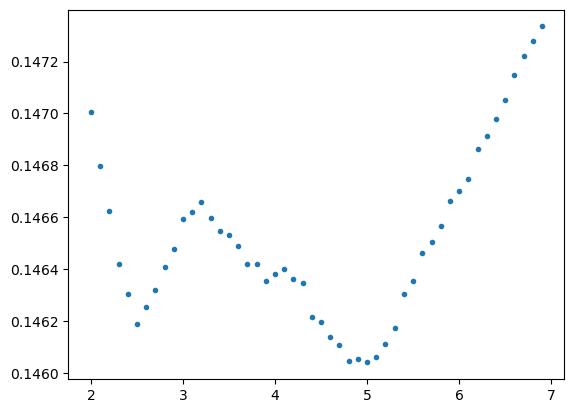

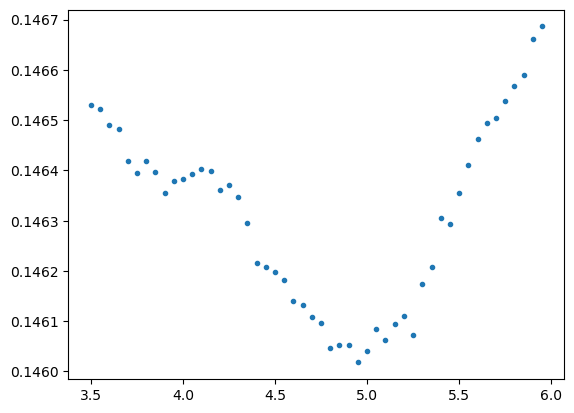

In [148]:
Cs1, svmRMSE1, smvR_2_01= train_SVR_C(1,25)
Cs2, svmRMSE2, smvR_2_02= train_SVR_C(20,70, zoom=10)
Cs3, svmRMSE3, smvR_2_03= train_SVR_C(70,120, zoom=20)

In [149]:
print('Mean val consumption: ',yval.mean())
opt_C = np.argmin(svmRMSE3)
best_RMSE_SVM = np.min(svmRMSE3)
print('Best RMSE SVM:', best_RMSE_SVM)
best_R2_SVM = np.min(smvR_2_03)
print('Best R2 SVM:', best_R2_SVM)
print(f'Best rel. RMSE {((best_RMSE_SVM/yval.mean())*0.01):.4f} %')

Mean val consumption:  1.305776401619324
Best RMSE SVM: 0.14601792375053854
Best R2 SVM: 0.9543223170231783
Best rel. RMSE 0.0011 %
